1. Import Necessary Libraries


In [422]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix


2. Load the Augmented Data


In [423]:
# Load the augmented dataset
df = pd.read_excel('augmented_data.xlsx')

# Display the first few rows
df.head()


,Réf. Art,Désignation,Collection,Famille,Fournisseur,Réf Fourn.,Qte,Unite,Tva,Prix d'achat,Prix de Vente,Prix TTC,Units Sold,Best Sold Period
0,SSW451,ZINC CIMENT,Collection_20,Famille_16,SOCIETÉ NEAPOLIS ORTHOPEDIE,392,0.0,unit,7,42.0560,56.0750,60.0003,274,8-2024 to 12-2024
1,ZHR300,ZETA PLUS PUTTY,Collection_34,Famille_18,CHEDENT,401,0.0,unit,7,56.0750,70.0935,75.0000,144,8-2024 to 11-2024
2,ZHE_200,ZETA FLOW LIGHT,Collection_34,Famille_3,P.M.S,404,6.0,g,19,20.1680,25.2100,29.9999,204,10-2024 to 10-2024
3,VO13,XTRAFIL,Collection_48,Famille_9,ORTHODENTAL TUNISIE,399,2.0,unit,7,112.1495,158.8785,170.0000,65,8-2024 to 10-2024
4,D-TECH004,XT-ETCH GEL 10GR,Collection_3,Famille_15,SIDEM,396,12.0,g,7,13.0000,18.6920,20.0004,380,2-2024 to 11-2024


3. Data Preprocessing and Feature Engineering


In [424]:
# Check for missing values
print(df.isnull().sum())


Réf. Art            0
Désignation         0
Collection          0
Famille             0
Fournisseur         0
Réf Fourn.          0
Qte                 0
Unite               0
Tva                 0
Prix d'achat        0
Prix de Vente       0
Prix TTC            0
Units Sold          0
Best Sold Period    0
dtype: int64


3.2. Encoding Categorical Variables


In [425]:
# List of categorical columns to encode
categorical_cols = ['Désignation', 'Collection', 'Famille', 'Fournisseur', 'Unite']

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to each column
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])


3.3. Parsing the Best Sold Period


In [426]:
# Function to extract start and end months
def extract_months(period):
    start_month = int(period.split('-')[0])
    end_month = int(period.split(' ')[0].split('-')[0])
    return start_month, end_month

# Apply the function to create new columns
df['Start_Month'], df['End_Month'] = zip(*df['Best Sold Period'].apply(extract_months))

# Drop the original 'Best Sold Period' column
df = df.drop('Best Sold Period', axis=1)


4. Exploratory Data Analysis (EDA)


4.1. Distribution of Units Sold


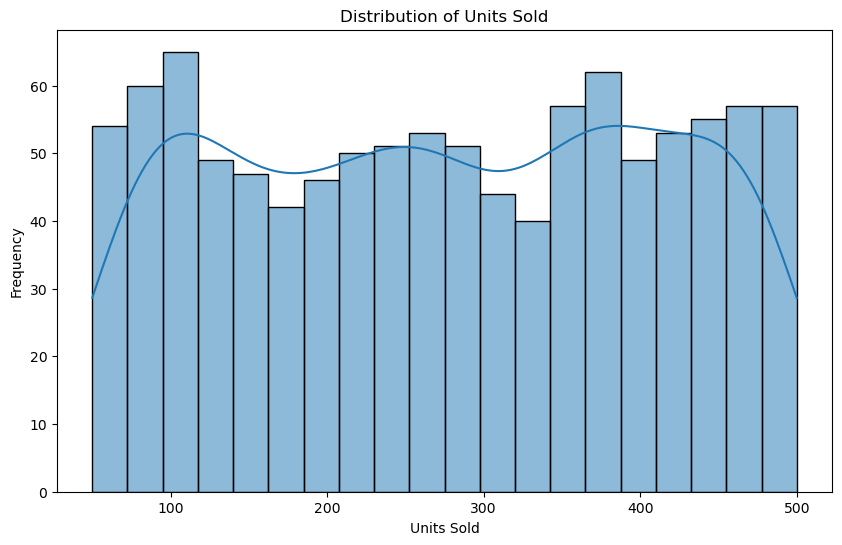

In [427]:
plt.figure(figsize=(10,6))
sns.histplot(df['Units Sold'], bins=20, kde=True)
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()


4.2. Correlation Heatmap


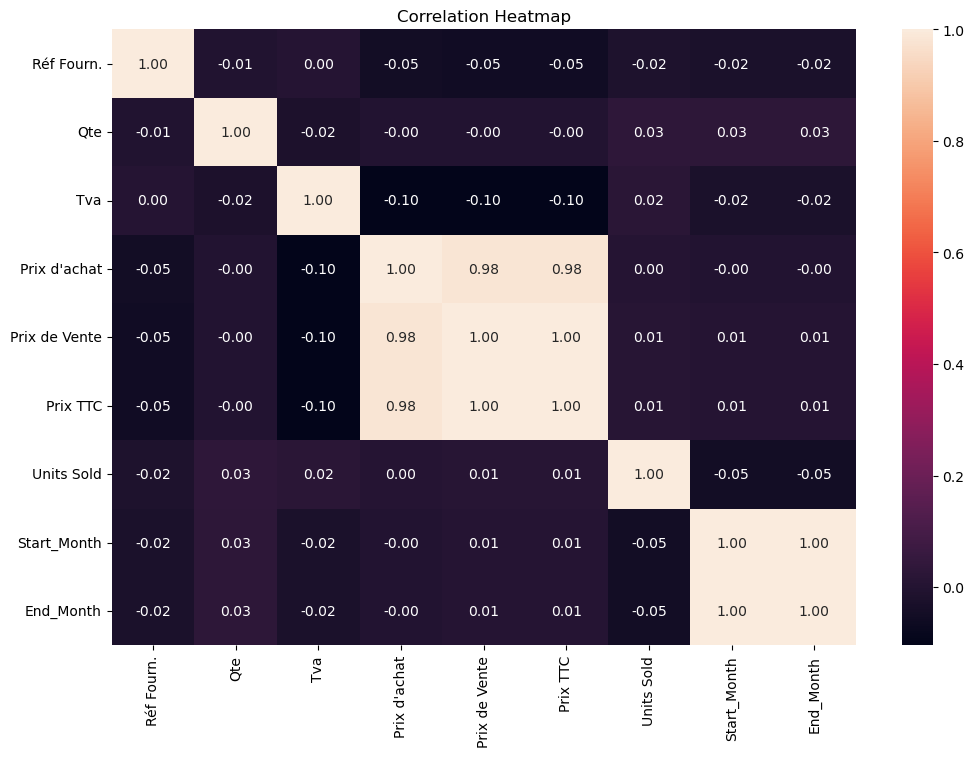

In [428]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

5. Building the Predictive Model




5.1. Creating the Target Variable


In [429]:
# Calculate the median units sold
median_units_sold = df['Units Sold'].median()

# Create the target variable
df['Sale_Category'] = df['Units Sold'].apply(lambda x: 'High Sale' if x > median_units_sold else 'Low Sale')

# Encode the target variable
df['Sale_Category'] = le.fit_transform(df['Sale_Category'])


5.2. Selecting Features and Target


In [430]:
# Features
X = df.drop(['Réf. Art', 'Units Sold', 'Sale_Category'], axis=1)

# Target
y = df['Sale_Category']



5.3. Splitting the Data



In [431]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


5.4. Training the Model


In [432]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

6. Evaluating the Model


6.1. Making Predictions


In [433]:
# Make predictions on the test set
y_pred = model.predict(X_test)


6.2. Classification Report


In [434]:
# Print classification report
print(classification_report(y_test, y_pred, target_names=['Low Sale', 'High Sale']))


              precision    recall  f1-score   support

    Low Sale       0.54      0.45      0.49       110
   High Sale       0.48      0.57      0.52        99

    accuracy                           0.51       209
   macro avg       0.51      0.51      0.51       209
weighted avg       0.51      0.51      0.51       209



6.3. Confusion Matrix


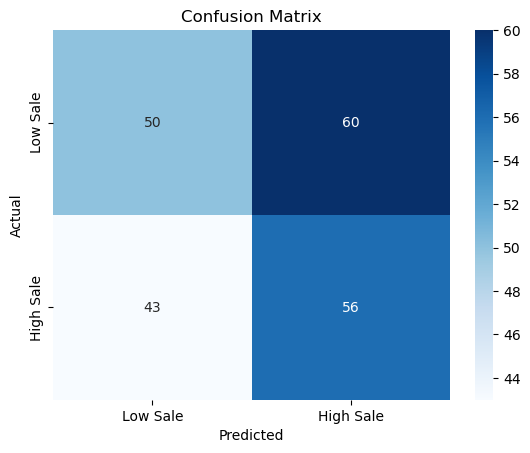

In [435]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Low Sale', 'High Sale'], yticklabels=['Low Sale', 'High Sale'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


7. Predicting Most Sold Articles for a Given Period


In [436]:
def predict_high_sale_articles(start_month, end_month):
    # Adjusted filtering condition
    period_df = df[(df['Start_Month'] <= end_month) & (df['End_Month'] >= start_month)]

    if period_df.empty:
        print("No articles found for the given period.")
        return pd.DataFrame()  # Return empty DataFrame or handle accordingly

    X_period = period_df.drop(['Réf. Art', 'Units Sold', 'Sale_Category'], axis=1)

    predictions = model.predict(X_period)
    period_df = period_df.copy()  # To avoid SettingWithCopyWarning
    period_df['Predicted_Sale_Category'] = predictions
    high_sale_articles = period_df[period_df['Predicted_Sale_Category'] == 1]
    return high_sale_articles[['Réf. Art', 'Désignation', 'Units Sold']]


In [437]:
start_month = 3
end_month = 5
high_sale_articles = predict_high_sale_articles(start_month, end_month)

if not high_sale_articles.empty:
    print("Predicted High Sale Articles from March to May 2024:")
    display(high_sale_articles)
else:
    print("No high sale articles predicted for the given period.")


Predicted High Sale Articles from March to May 2024:


,Réf. Art,Désignation,Units Sold
18,MOL 125,1014,58
19,DE600-503-30,1013,118
21,CO245,1011,161
27,ZIANN03,1004,107
28,DIV9547,1003,266
...,...,...,...
1010,ZHR1,30,90
1012,CV12,28,129
1020,DIV4571,20,252
1027,BE03,13,81


In [438]:
import joblib

# Save the trained model to a file
model_filename = 'decision_tree_model.joblib'
joblib.dump(model, model_filename)

print(f"Model saved to {model_filename}")


Model saved to decision_tree_model.joblib


In [439]:
from sklearn.preprocessing import LabelEncoder

encoders = {}
categorical_cols = ['Désignation', 'Collection', 'Famille', 'Fournisseur', 'Unite']

for col in categorical_cols:
    le = LabelEncoder()
    le.fit(df[col])  # Fit on original string data
    df[col] = le.transform(df[col])  # Transform the data
    encoders[col] = le

In [440]:
# Save the encoders dictionary
joblib.dump(encoders, 'label_encoderss.joblib')


['label_encoderss.joblib']

In [441]:
median_filename = 'median_units_sold.joblib'
joblib.dump(median_units_sold, median_filename)


['median_units_sold.joblib']

In [442]:
features_filename = 'model_features.joblib'
joblib.dump(X_train.columns.tolist(), features_filename)


['model_features.joblib']

   Réf. Art       Désignation    Collection      Famille Fournisseur  \
0  REF_9764       ZINC CIMENT  Restauration      Ciments  INVENTAIRE   
1  REF_6431   ZETA PLUS PUTTY    Impression     Silicone       P.M.S   
2  REF_3461   ZETA FLOW LIGHT    Impression     Silicone       P.M.S   
3  REF_1720           XTRAFIL  Restauration   Composites        SETS   
4  REF_5396  XT-ETCH GEL 10GR      Adhésifs  Gel d’acide  DISTRI-MED   

   FournisseurID  Qte Unite  Tva  Prix d'achat  Prix de Vente  Prix TTC  
0              1   46     g   20        507.34         523.05    580.74  
1             14    9    ml   20        729.37         814.35    868.58  
2             14   92    ml    7        866.69        1320.05   1455.66  
3              8    8     g   20        833.56         966.00   1090.17  
4              4   28     g   19        574.54         723.83    860.05  


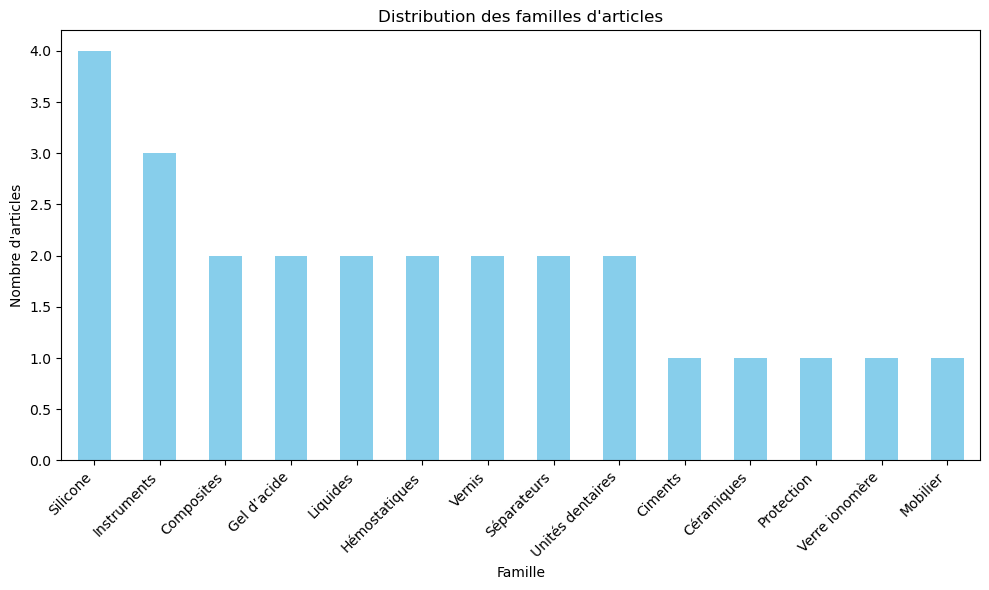

In [443]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier Excel
file_path = 'C:/Users/ismae/Downloads/powerbi-main/powerbi-main/data final/NEWarticles_medical.xls'
df = pd.read_excel(file_path)

# Afficher les premières lignes pour vérifier le contenu
print(df.head())

# Grouper les données par famille et compter le nombre d'articles dans chaque famille
family_counts = df['Famille'].value_counts()

# Tracer un graphique à barres pour montrer la distribution des familles d'articles
plt.figure(figsize=(10, 6))
family_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution des familles d\'articles')
plt.xlabel('Famille')
plt.ylabel('Nombre d\'articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher le graphique
plt.show()


   Réf. Art       Désignation    Collection      Famille Fournisseur  \
0  REF_9764       ZINC CIMENT  Restauration      Ciments  INVENTAIRE   
1  REF_6431   ZETA PLUS PUTTY    Impression     Silicone       P.M.S   
2  REF_3461   ZETA FLOW LIGHT    Impression     Silicone       P.M.S   
3  REF_1720           XTRAFIL  Restauration   Composites        SETS   
4  REF_5396  XT-ETCH GEL 10GR      Adhésifs  Gel d’acide  DISTRI-MED   

   FournisseurID  Qte Unite  Tva  Prix d'achat  Prix de Vente  Prix TTC  
0              1   46     g   20        507.34         523.05    580.74  
1             14    9    ml   20        729.37         814.35    868.58  
2             14   92    ml    7        866.69        1320.05   1455.66  
3              8    8     g   20        833.56         966.00   1090.17  
4              4   28     g   19        574.54         723.83    860.05  


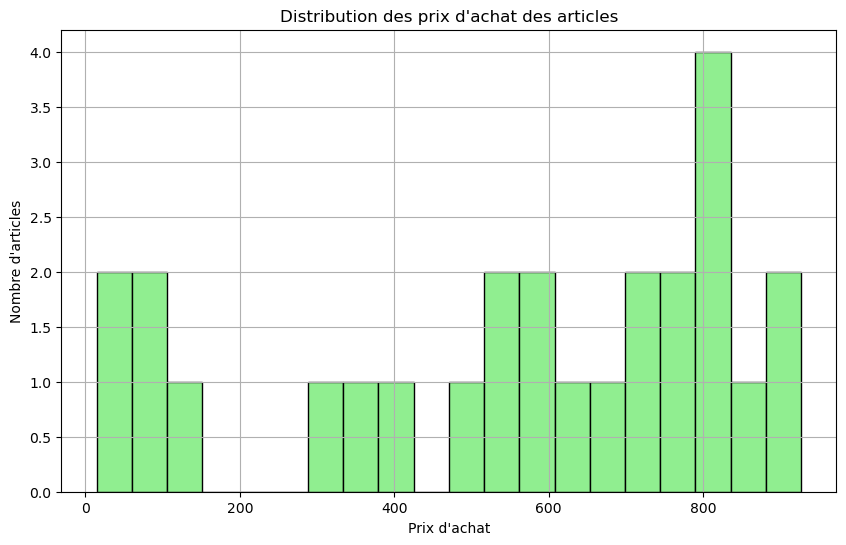

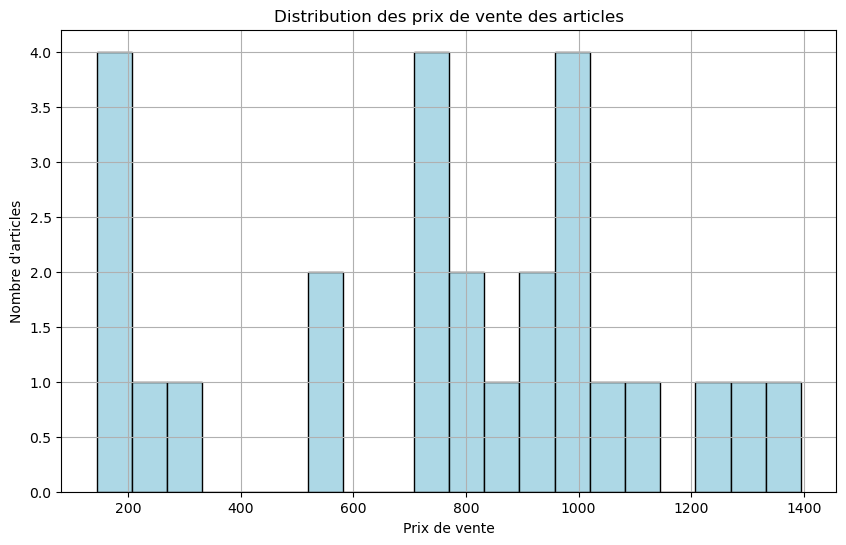

In [444]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier Excel
file_path = 'C:/Users/ismae/Downloads/powerbi-main/powerbi-main/data final/NEWarticles_medical.xls'
df = pd.read_excel(file_path)

# Afficher les premières lignes pour vérifier le contenu
print(df.head())

# Distribution des prix d'achat
plt.figure(figsize=(10, 6))
plt.hist(df['Prix d\'achat'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Distribution des prix d\'achat des articles')
plt.xlabel('Prix d\'achat')
plt.ylabel('Nombre d\'articles')
plt.grid(True)

# Afficher le graphique
plt.show()

# Distribution des prix de vente
plt.figure(figsize=(10, 6))
plt.hist(df['Prix de Vente'], bins=20, color='lightblue', edgecolor='black')
plt.title('Distribution des prix de vente des articles')
plt.xlabel('Prix de vente')
plt.ylabel('Nombre d\'articles')
plt.grid(True)

# Afficher le graphique
plt.show()


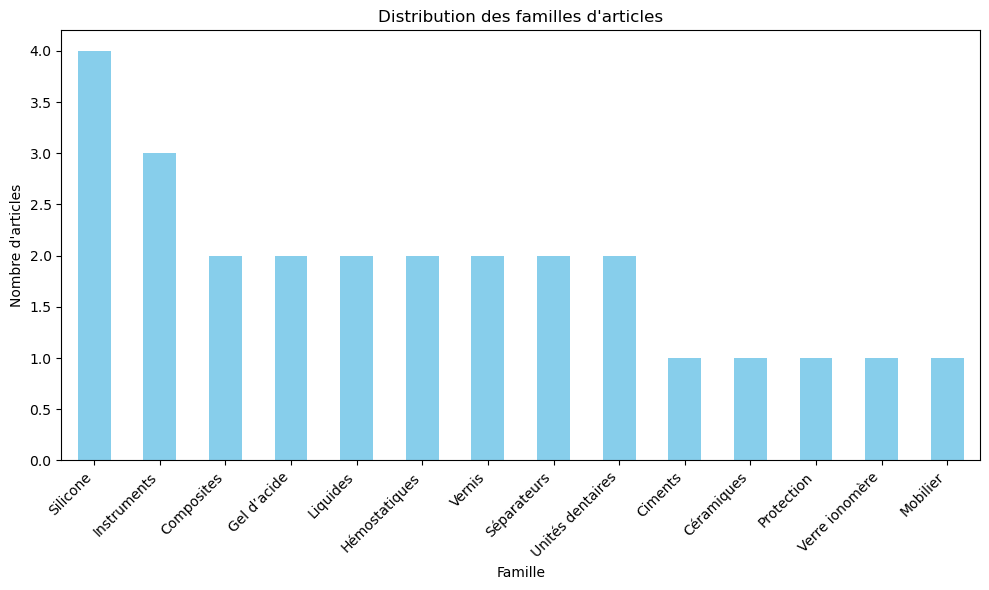

In [445]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier Excel
file_path = 'C:/Users/ismae/Downloads/powerbi-main/powerbi-main/data final/NEWarticles_medical.xls'
df = pd.read_excel(file_path)

# Grouper les données par famille et compter le nombre d'articles dans chaque famille
family_counts = df['Famille'].value_counts()

# Tracer un graphique à barres pour montrer la distribution des familles d'articles
plt.figure(figsize=(10, 6))
family_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution des familles d\'articles')
plt.xlabel('Famille')
plt.ylabel('Nombre d\'articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher le graphique
plt.show()


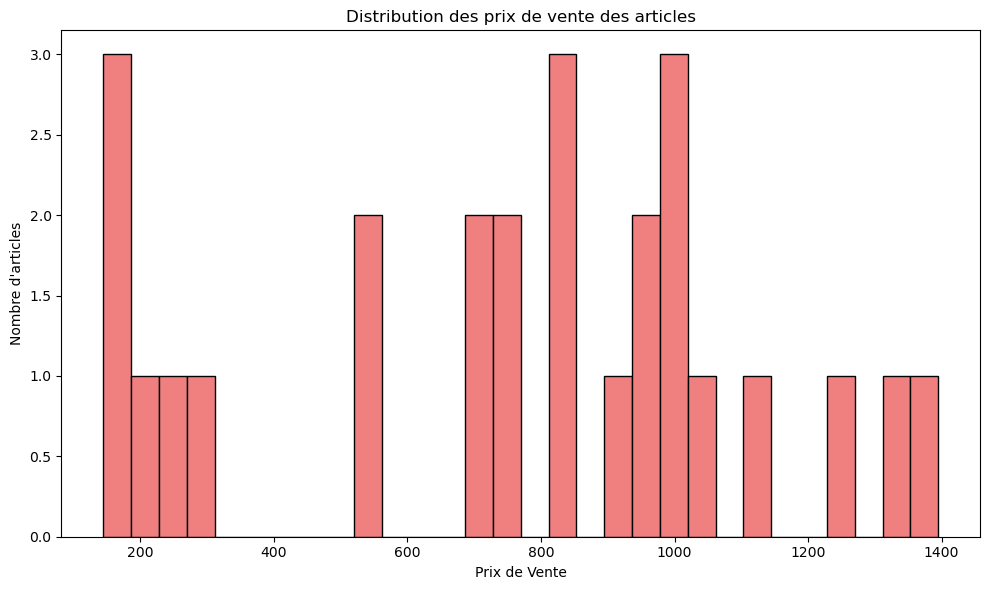

In [446]:
# Tracer un histogramme pour montrer la distribution des prix de vente
plt.figure(figsize=(10, 6))
plt.hist(df['Prix de Vente'], bins=30, color='lightcoral', edgecolor='black')
plt.title('Distribution des prix de vente des articles')
plt.xlabel('Prix de Vente')
plt.ylabel('Nombre d\'articles')
plt.tight_layout()

# Afficher le graphique
plt.show()


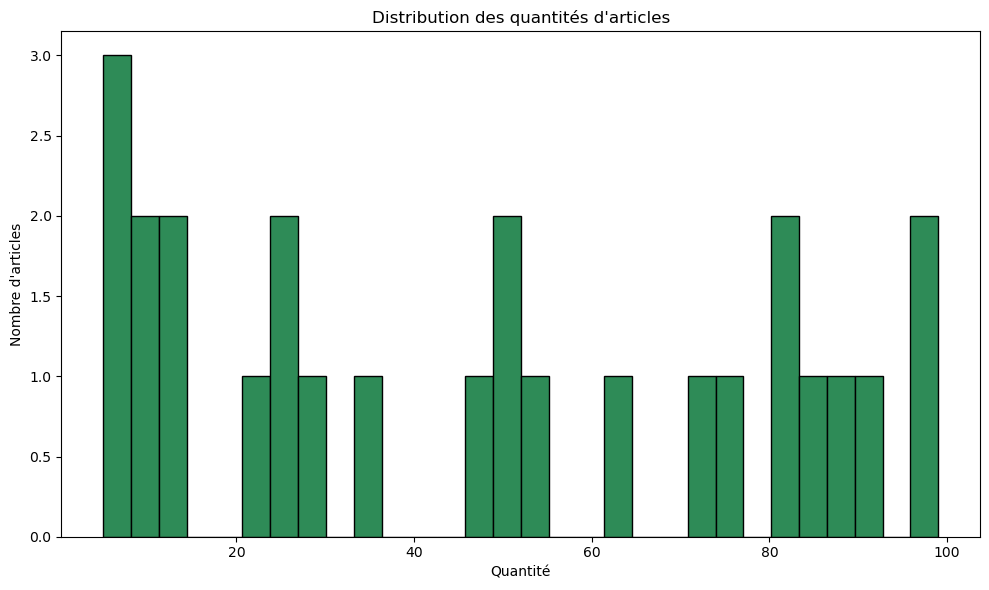

In [447]:
# Tracer un histogramme pour montrer la distribution des quantités d'articles
plt.figure(figsize=(10, 6))
plt.hist(df['Qte'], bins=30, color='seagreen', edgecolor='black')
plt.title('Distribution des quantités d\'articles')
plt.xlabel('Quantité')
plt.ylabel('Nombre d\'articles')
plt.tight_layout()

# Afficher le graphique
plt.show()


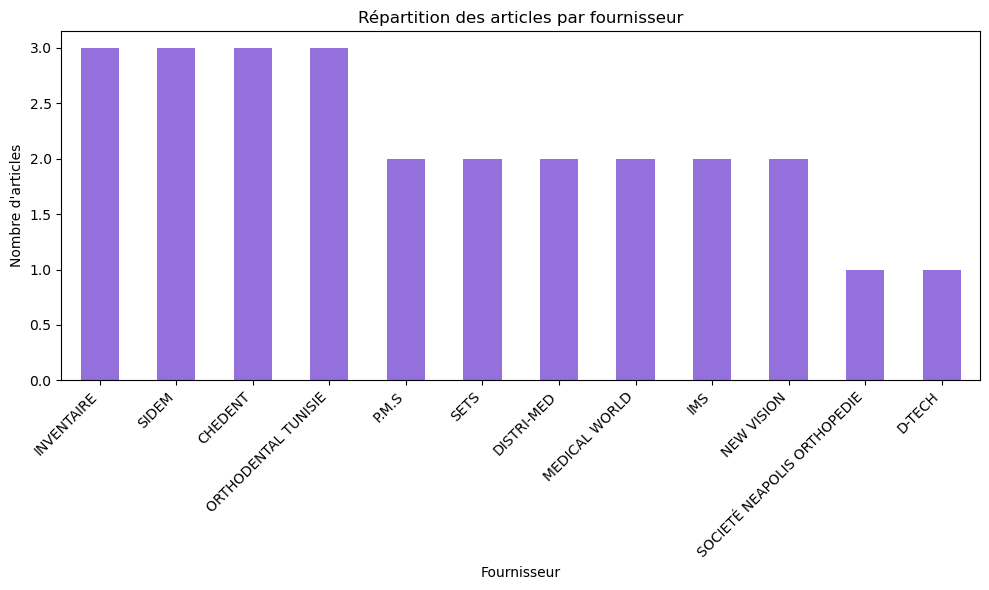

In [448]:
# Grouper les données par fournisseur et compter le nombre d'articles
fournisseur_counts = df['Fournisseur'].value_counts()

# Tracer un graphique à barres pour montrer la répartition des articles par fournisseur
plt.figure(figsize=(10, 6))
fournisseur_counts.plot(kind='bar', color='mediumpurple')
plt.title('Répartition des articles par fournisseur')
plt.xlabel('Fournisseur')
plt.ylabel('Nombre d\'articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher le graphique
plt.show()


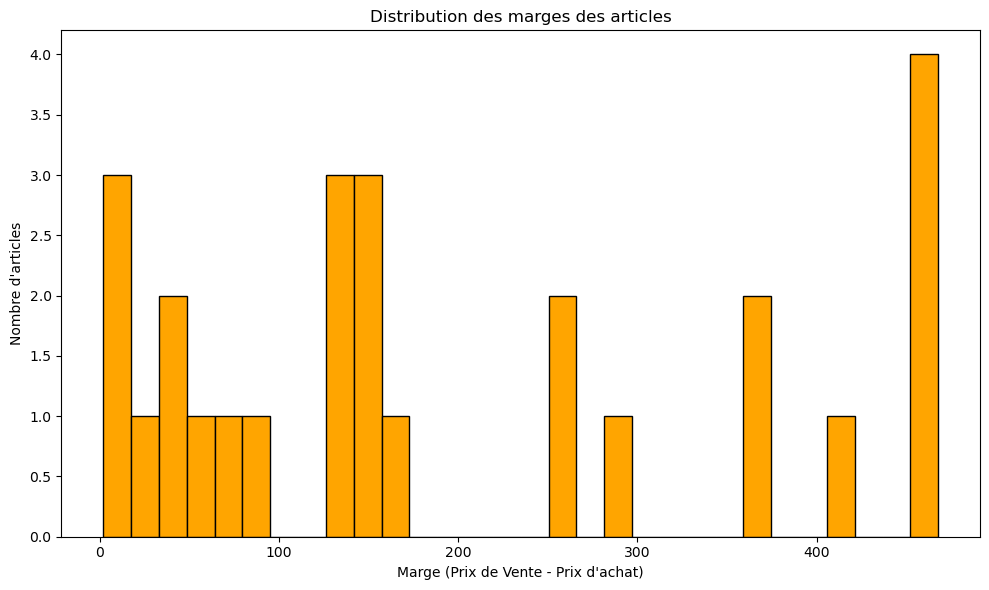

In [449]:
# Calculer les marges (prix de vente - prix d'achat)
df['Marge'] = df['Prix de Vente'] - df['Prix d\'achat']

# Tracer un histogramme pour montrer la distribution des marges
plt.figure(figsize=(10, 6))
plt.hist(df['Marge'], bins=30, color='orange', edgecolor='black')
plt.title('Distribution des marges des articles')
plt.xlabel('Marge (Prix de Vente - Prix d\'achat)')
plt.ylabel('Nombre d\'articles')
plt.tight_layout()

# Afficher le graphique
plt.show()


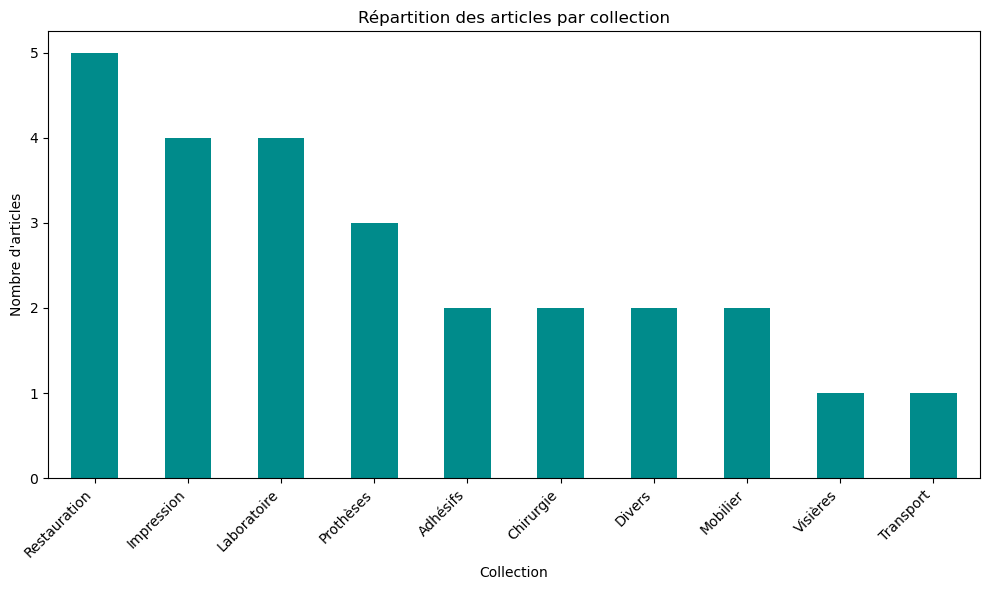

In [450]:
# Grouper les données par collection et compter le nombre d'articles
collection_counts = df['Collection'].value_counts()

# Tracer un graphique à barres pour montrer la répartition des articles par collection
plt.figure(figsize=(10, 6))
collection_counts.plot(kind='bar', color='darkcyan')
plt.title('Répartition des articles par collection')
plt.xlabel('Collection')
plt.ylabel('Nombre d\'articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher le graphique
plt.show()


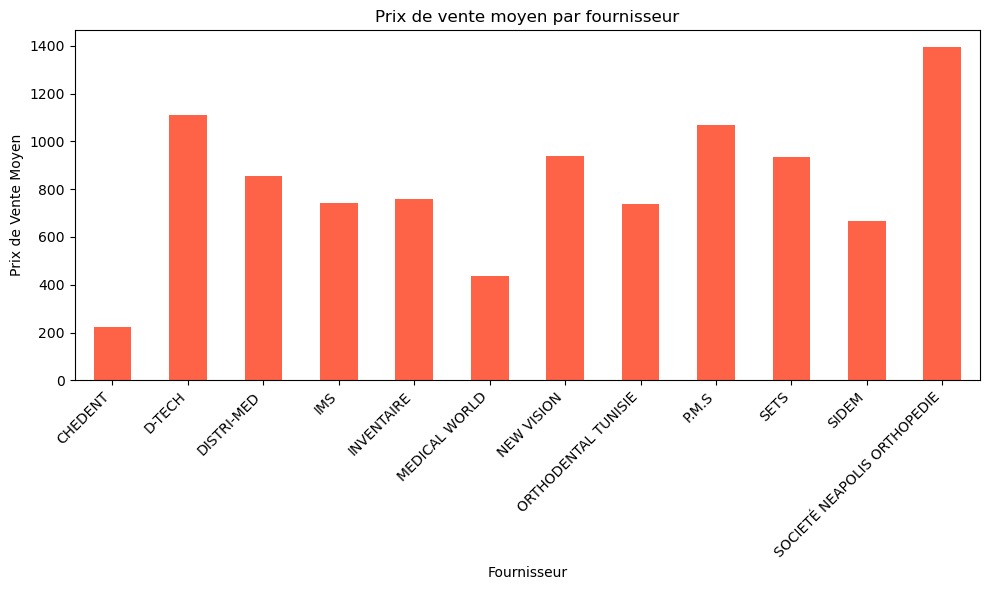

In [451]:
# Grouper par fournisseur et calculer le prix de vente moyen
prix_moyen_fournisseur = df.groupby('Fournisseur')['Prix de Vente'].mean()

# Tracer un graphique à barres
plt.figure(figsize=(10, 6))
prix_moyen_fournisseur.plot(kind='bar', color='tomato')
plt.title('Prix de vente moyen par fournisseur')
plt.xlabel('Fournisseur')
plt.ylabel('Prix de Vente Moyen')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Afficher le graphique
plt.show()


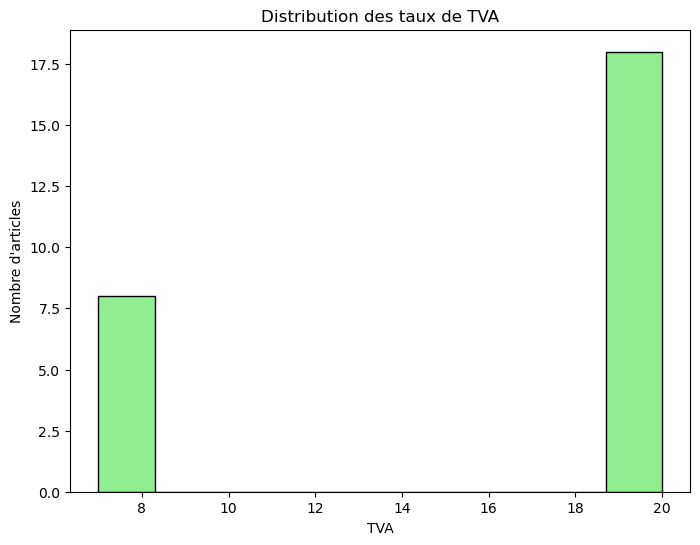

In [452]:
# Histogramme de la distribution des taux de TVA
plt.figure(figsize=(8, 6))
plt.hist(df['Tva'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Distribution des taux de TVA')
plt.xlabel('TVA')
plt.ylabel('Nombre d\'articles')
plt.show()


<Figure size 1000x600 with 0 Axes>

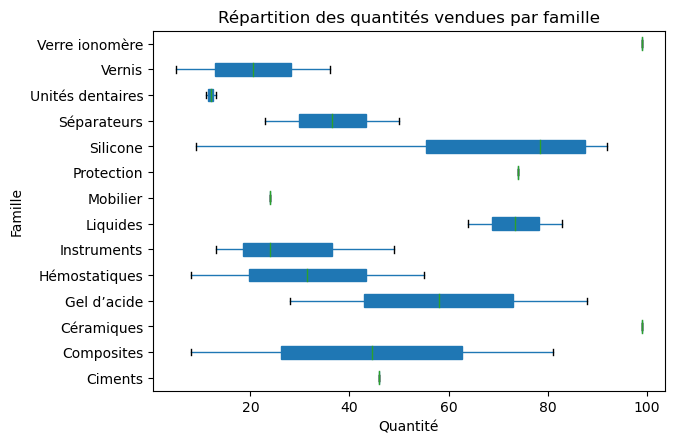

In [453]:
# Box plot des quantités vendues par famille
plt.figure(figsize=(10, 6))
df.boxplot(column='Qte', by='Famille', grid=False, vert=False, patch_artist=True)
plt.title('Répartition des quantités vendues par famille')
plt.suptitle('')  # Remove automatic title
plt.xlabel('Quantité')
plt.ylabel('Famille')
plt.show()


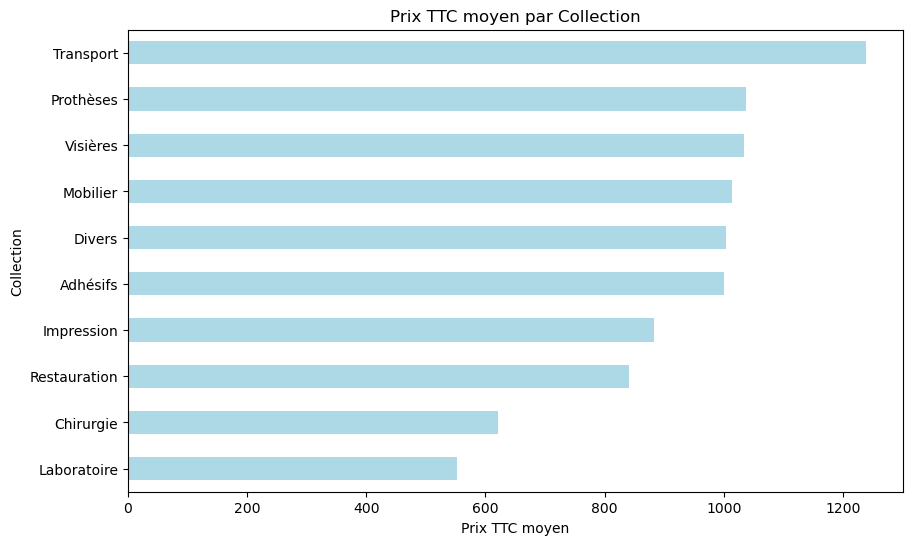

In [454]:
# Comparaison des prix TTC moyens par collection
collection_prices = df.groupby('Collection')['Prix TTC'].mean().sort_values()

plt.figure(figsize=(10, 6))
collection_prices.plot(kind='barh', color='lightblue')
plt.title('Prix TTC moyen par Collection')
plt.xlabel('Prix TTC moyen')
plt.ylabel('Collection')
plt.show()


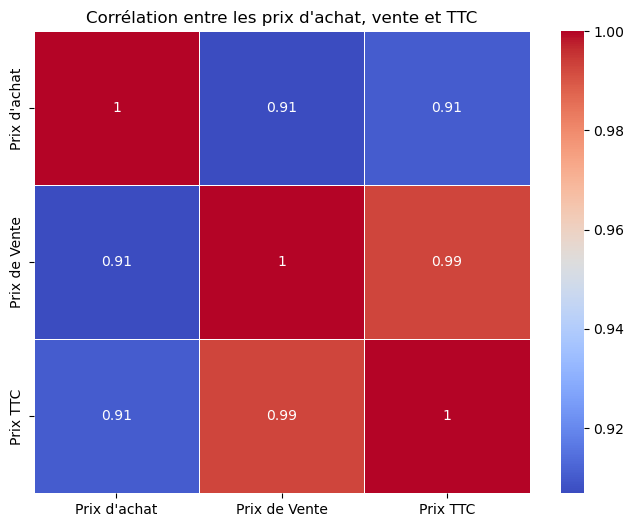

In [455]:
import seaborn as sns

# Corrélation entre prix d'achat, prix de vente et prix TTC
plt.figure(figsize=(8, 6))
correlation_matrix = df[['Prix d\'achat', 'Prix de Vente', 'Prix TTC']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Corrélation entre les prix d\'achat, vente et TTC')
plt.show()


In [1]:
# Evolution des prix de vente moyens par collection (Line plot)
collection_avg_price = df.groupby('Collection')['Prix de Vente'].mean().sort_values()

plt.figure(figsize=(10, 6))
collection_avg_price.plot(kind='line', marker='o', color='purple')
plt.title('Evolution des prix de vente moyens par Collection')
plt.xlabel('Collection')
plt.ylabel('Prix de Vente moyen')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


NameError: name 'df' is not defined

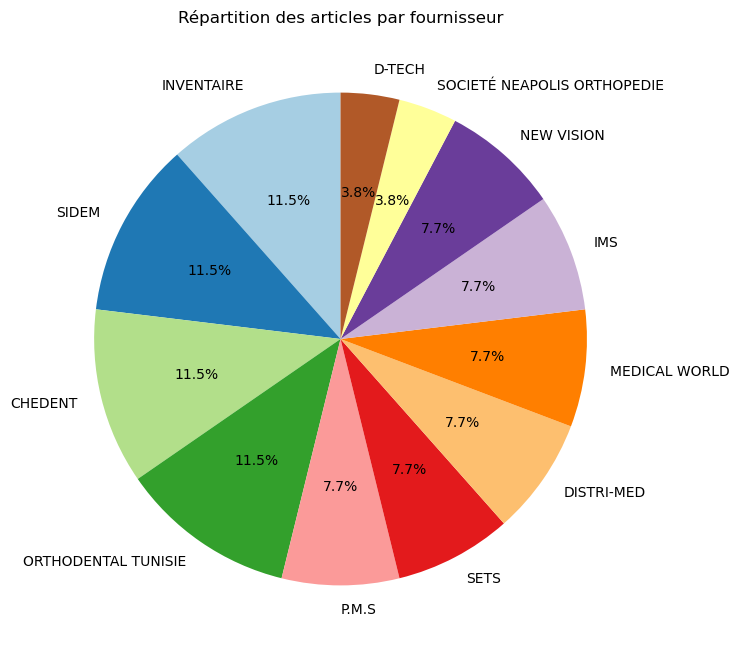

In [457]:
# Répartition des fournisseurs (Pie chart)
supplier_counts = df['Fournisseur'].value_counts()

plt.figure(figsize=(8, 8))
supplier_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Répartition des articles par fournisseur')
plt.ylabel('')
plt.show()
